In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import fastai
from fastai.train import Learner
from fastai.train import DataBunch
from fastai.callbacks import *
from fastai.basic_data import DatasetType
import fastprogress
from fastprogress import force_console_behavior
import numpy as np
from pprint import pprint
import pandas as pd
import os
import time

import gc
import random
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
from keras.preprocessing import text, sequence
import torch
from torch import nn
from torch.utils import data
from torch.nn import functional as F


Using TensorFlow backend.


In [2]:
tqdm.pandas()

In [3]:
def seed_everything(seed=123):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

** To replace the pretrained embedding files with their pickle corresponds. Loading a pickled version (most other public kernels)**

In [4]:
CRAWL_EMBEDDING_PATH = '../embeddings/crawl-300d-2M.pkl'
GLOVE_EMBEDDING_PATH = '../embeddings/glove.840B.300d.pkl'
#GOOGLE_EMBEDDING_PATH = '../input/quoratextemb/embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin'
#WIKI_EMBEDDING_PATH = '../input/quoratextemb/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec'

* To adjust the load_embeddings function (Pickled dict).

In [5]:
NUM_MODELS = 2
LSTM_UNITS = 128
DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS
MAX_LEN = 220

def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')


def load_embeddings(path):
    with open(path,'rb') as f:
        emb_arr = pickle.load(f)
    return emb_arr

* To try a "lower/upper case version of a" word if an embedding is not found, which sometimes gives us an embedding

In [6]:
def words(text): return re.findall(r'\w+', text.lower())
def P(word): 
    "Probability of `word`."
    # use inverse of rank as proxy
    # returns 0 if the word isn't in the dictionary
    return - WORDS.get(word, 0)
def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)
def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or [word])
def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)
def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)
def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))
def singlify(word):
    return "".join([letter for i,letter in enumerate(word) if i == 0 or letter != word[i-1]])

In [7]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()

def build_matrix(word_index, path):
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((max_features + 1, 300))
    unknown_words = []
    
    for word, i in word_index.items():
        if i <= max_features:
            try:
                embedding_matrix[i] = embedding_index[word]
            except KeyError:
                try:
                    embedding_matrix[i] = embedding_index[word.lower()]
                except KeyError:
                    try:
                        embedding_matrix[i] = embedding_index[word.title()]
                    except KeyError:
                        unknown_words.append(word)
                        try:
                            embedding_matrix[i] = embedding_index[word.capitalize()]
                        except KeyError:
                            try:
                                embedding_matrix[i] = embedding_index[ps.stem(word)]
                            except KeyError:
                                unknown_words.append(word)
    return embedding_matrix, unknown_words

In [8]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class SpatialDropout(nn.Dropout2d):
    def forward(self, x):
        x = x.unsqueeze(2)    # (N, T, 1, K)
        x = x.permute(0, 3, 2, 1)  # (N, K, 1, T)
        x = super(SpatialDropout, self).forward(x)  # (N, K, 1, T), some features are masked
        x = x.permute(0, 3, 2, 1)  # (N, T, 1, K)
        x = x.squeeze(2)  # (N, T, K)
        return x

def train_model(learn,test,output_dim,lr=0.001,
                batch_size=512, n_epochs=5,
                enable_checkpoint_ensemble=True):
    
    all_test_preds = []
    checkpoint_weights = [2 ** epoch for epoch in range(n_epochs)]
    test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)
    n = len(learn.data.train_dl)
    phases = [(TrainingPhase(n).schedule_hp('lr', lr * (0.6**(i)))) for i in range(n_epochs)]
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    for epoch in range(n_epochs):
        learn.fit(1)
        test_preds = np.zeros((len(test), output_dim))    
        for i, x_batch in enumerate(test_loader):
            X = x_batch[0].cuda()
            y_pred = sigmoid(learn.model(X).detach().cpu().numpy())
            test_preds[i * batch_size:(i+1) * batch_size, :] = y_pred

        all_test_preds.append(test_preds)


    if enable_checkpoint_ensemble:
        test_preds = np.average(all_test_preds, weights=checkpoint_weights, axis=0)    
    else:
        test_preds = all_test_preds[-1]
        
    return test_preds

In [9]:
train = pd.read_csv('../data/train.csv')
identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']
    
test = train.loc[train[identity_columns].isnull().sum(axis=1)>0]
train = train.loc[train[identity_columns].isnull().sum(axis=1)==0]

## Preprocessing

In [11]:
symbols_to_isolate = '.,?!-;*"…:—()%#$&_/@＼・ω+=”“[]^–>\\°<~•≠™ˈʊɒ∞§{}·τα❤☺ɡ|¢→̶`❥━┣┫┗Ｏ►★©―ɪ✔®\x96\x92●£♥➤´¹☕≈÷♡◐║▬′ɔː€۩۞†μ✒➥═☆ˌ◄½ʻπδηλσερνʃ✬ＳＵＰＥＲＩＴ☻±♍µº¾✓◾؟．⬅℅»Вав❣⋅¿¬♫ＣＭβ█▓▒░⇒⭐›¡₂₃❧▰▔◞▀▂▃▄▅▆▇↙γ̄″☹➡«φ⅓„✋：¥̲̅́∙‛◇✏▷❓❗¶˚˙）сиʿ✨。ɑ\x80◕！％¯−ﬂﬁ₁²ʌ¼⁴⁄₄⌠♭✘╪▶☭✭♪☔☠♂☃☎✈✌✰❆☙○‣⚓年∎ℒ▪▙☏⅛ｃａｓǀ℮¸ｗ‚∼‖ℳ❄←☼⋆ʒ⊂、⅔¨͡๏⚾⚽Φ×θ￦？（℃⏩☮⚠月✊❌⭕▸■⇌☐☑⚡☄ǫ╭∩╮，例＞ʕɐ̣Δ₀✞┈╱╲▏▕┃╰▊▋╯┳┊≥☒↑☝ɹ✅☛♩☞ＡＪＢ◔◡↓♀⬆̱ℏ\x91⠀ˤ╚↺⇤∏✾◦♬³の｜／∵∴√Ω¤☜▲↳▫‿⬇✧ｏｖｍ－２０８＇‰≤∕ˆ⚜☁'
symbols_to_delete = '\n🍕\r🐵😑\xa0\ue014\t\uf818\uf04a\xad😢🐶️\uf0e0😜😎👊\u200b\u200e😁عدويهصقأناخلىبمغر😍💖💵Е👎😀😂\u202a\u202c🔥😄🏻💥ᴍʏʀᴇɴᴅᴏᴀᴋʜᴜʟᴛᴄᴘʙғᴊᴡɢ😋👏שלוםבי😱‼\x81エンジ故障\u2009🚌ᴵ͞🌟😊😳😧🙀😐😕\u200f👍😮😃😘אעכח💩💯⛽🚄🏼ஜ😖ᴠ🚲‐😟😈💪🙏🎯🌹😇💔😡\x7f👌ἐὶήιὲκἀίῃἴξ🙄Ｈ😠\ufeff\u2028😉😤⛺🙂\u3000تحكسة👮💙فزط😏🍾🎉😞\u2008🏾😅😭👻😥😔😓🏽🎆🍻🍽🎶🌺🤔😪\x08‑🐰🐇🐱🙆😨🙃💕𝘊𝘦𝘳𝘢𝘵𝘰𝘤𝘺𝘴𝘪𝘧𝘮𝘣💗💚地獄谷улкнПоАН🐾🐕😆ה🔗🚽歌舞伎🙈😴🏿🤗🇺🇸мυтѕ⤵🏆🎃😩\u200a🌠🐟💫💰💎эпрд\x95🖐🙅⛲🍰🤐👆🙌\u2002💛🙁👀🙊🙉\u2004ˢᵒʳʸᴼᴷᴺʷᵗʰᵉᵘ\x13🚬🤓\ue602😵άοόςέὸתמדףנרךצט😒͝🆕👅👥👄🔄🔤👉👤👶👲🔛🎓\uf0b7\uf04c\x9f\x10成都😣⏺😌🤑🌏😯ех😲Ἰᾶὁ💞🚓🔔📚🏀👐\u202d💤🍇\ue613小土豆🏡❔⁉\u202f👠》कर्मा🇹🇼🌸蔡英文🌞🎲レクサス😛外国人关系Сб💋💀🎄💜🤢َِьыгя不是\x9c\x9d🗑\u2005💃📣👿༼つ༽😰ḷЗз▱ц￼🤣卖温哥华议会下降你失去所有的钱加拿大坏税骗子🐝ツ🎅\x85🍺آإشء🎵🌎͟ἔ油别克🤡🤥😬🤧й\u2003🚀🤴ʲшчИОРФДЯМюж😝🖑ὐύύ特殊作戦群щ💨圆明园קℐ🏈😺🌍⏏ệ🍔🐮🍁🍆🍑🌮🌯🤦\u200d𝓒𝓲𝓿𝓵안영하세요ЖљКћ🍀😫🤤ῦ我出生在了可以说普通话汉语好极🎼🕺🍸🥂🗽🎇🎊🆘🤠👩🖒🚪天一家⚲\u2006⚭⚆⬭⬯⏖新✀╌🇫🇷🇩🇪🇮🇬🇧😷🇨🇦ХШ🌐\x1f杀鸡给猴看ʁ𝗪𝗵𝗲𝗻𝘆𝗼𝘂𝗿𝗮𝗹𝗶𝘇𝗯𝘁𝗰𝘀𝘅𝗽𝘄𝗱📺ϖ\u2000үսᴦᎥһͺ\u2007հ\u2001ɩｙｅ൦ｌƽｈ𝐓𝐡𝐞𝐫𝐮𝐝𝐚𝐃𝐜𝐩𝐭𝐢𝐨𝐧Ƅᴨןᑯ໐ΤᏧ௦Іᴑ܁𝐬𝐰𝐲𝐛𝐦𝐯𝐑𝐙𝐣𝐇𝐂𝐘𝟎ԜТᗞ౦〔Ꭻ𝐳𝐔𝐱𝟔𝟓𝐅🐋ﬃ💘💓ё𝘥𝘯𝘶💐🌋🌄🌅𝙬𝙖𝙨𝙤𝙣𝙡𝙮𝙘𝙠𝙚𝙙𝙜𝙧𝙥𝙩𝙪𝙗𝙞𝙝𝙛👺🐷ℋ𝐀𝐥𝐪🚶𝙢Ἱ🤘ͦ💸ج패티Ｗ𝙇ᵻ👂👃ɜ🎫\uf0a7БУі🚢🚂ગુજરાતીῆ🏃𝓬𝓻𝓴𝓮𝓽𝓼☘﴾̯﴿₽\ue807𝑻𝒆𝒍𝒕𝒉𝒓𝒖𝒂𝒏𝒅𝒔𝒎𝒗𝒊👽😙\u200cЛ‒🎾👹⎌🏒⛸公寓养宠物吗🏄🐀🚑🤷操美𝒑𝒚𝒐𝑴🤙🐒欢迎来到阿拉斯ספ𝙫🐈𝒌𝙊𝙭𝙆𝙋𝙍𝘼𝙅ﷻ🦄巨收赢得白鬼愤怒要买额ẽ🚗🐳𝟏𝐟𝟖𝟑𝟕𝒄𝟗𝐠𝙄𝙃👇锟斤拷𝗢𝟳𝟱𝟬⦁マルハニチロ株式社⛷한국어ㄸㅓ니͜ʖ𝘿𝙔₵𝒩ℯ𝒾𝓁𝒶𝓉𝓇𝓊𝓃𝓈𝓅ℴ𝒻𝒽𝓀𝓌𝒸𝓎𝙏ζ𝙟𝘃𝗺𝟮𝟭𝟯𝟲👋🦊多伦🐽🎻🎹⛓🏹🍷🦆为和中友谊祝贺与其想象对法如直接问用自己猜本传教士没积唯认识基督徒曾经让相信耶稣复活死怪他但当们聊些政治题时候战胜因圣把全堂结婚孩恐惧且栗谓这样还♾🎸🤕🤒⛑🎁批判检讨🏝🦁🙋😶쥐스탱트뤼도석유가격인상이경제황을렵게만들지않록잘관리해야합다캐나에서대마초와화약금의품런성분갈때는반드시허된사용🔫👁凸ὰ💲🗯𝙈Ἄ𝒇𝒈𝒘𝒃𝑬𝑶𝕾𝖙𝖗𝖆𝖎𝖌𝖍𝖕𝖊𝖔𝖑𝖉𝖓𝖐𝖜𝖞𝖚𝖇𝕿𝖘𝖄𝖛𝖒𝖋𝖂𝕴𝖟𝖈𝕸👑🚿💡知彼百\uf005𝙀𝒛𝑲𝑳𝑾𝒋𝟒😦𝙒𝘾𝘽🏐𝘩𝘨ὼṑ𝑱𝑹𝑫𝑵𝑪🇰🇵👾ᓇᒧᔭᐃᐧᐦᑳᐨᓃᓂᑲᐸᑭᑎᓀᐣ🐄🎈🔨🐎🤞🐸💟🎰🌝🛳点击查版🍭𝑥𝑦𝑧ＮＧ👣\uf020っ🏉ф💭🎥Ξ🐴👨🤳🦍\x0b🍩𝑯𝒒😗𝟐🏂👳🍗🕉🐲چی𝑮𝗕𝗴🍒ꜥⲣⲏ🐑⏰鉄リ事件ї💊「」\uf203\uf09a\uf222\ue608\uf202\uf099\uf469\ue607\uf410\ue600燻製シ虚偽屁理屈Г𝑩𝑰𝒀𝑺🌤𝗳𝗜𝗙𝗦𝗧🍊ὺἈἡχῖΛ⤏🇳𝒙ψՁմեռայինրւդձ冬至ὀ𝒁🔹🤚🍎𝑷🐂💅𝘬𝘱𝘸𝘷𝘐𝘭𝘓𝘖𝘹𝘲𝘫کΒώ💢ΜΟΝΑΕ🇱♲𝝈↴💒⊘Ȼ🚴🖕🖤🥘📍👈➕🚫🎨🌑🐻𝐎𝐍𝐊𝑭🤖🎎😼🕷ｇｒｎｔｉｄｕｆｂｋ𝟰🇴🇭🇻🇲𝗞𝗭𝗘𝗤👼📉🍟🍦🌈🔭《🐊🐍\uf10aლڡ🐦\U0001f92f\U0001f92a🐡💳ἱ🙇𝗸𝗟𝗠𝗷🥜さようなら🔼'

In [12]:
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
small_caps_mapping = { 
"ᴀ": "a", "ʙ": "b", "ᴄ": "c", "ᴅ": "d", "ᴇ": "e", "ғ": "f", "ɢ": "g", "ʜ": "h", "ɪ": "i", 
"ᴊ": "j", "ᴋ": "k", "ʟ": "l", "ᴍ": "m", "ɴ": "n", "ᴏ": "o", "ᴘ": "p", "ǫ": "q", "ʀ": "r", 
"s": "s", "ᴛ": "t", "ᴜ": "u", "ᴠ": "v", "ᴡ": "w", "x": "x", "ʏ": "y", "ᴢ": "z"}
contraction_mapping = {
"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", 
"didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", 
"he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  
"I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": 
"i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", 
"it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", 
"mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", 
"mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
"o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", 
"sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", 
"she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", 
"shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's":"this is","that'd": "that would", 
"that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", 
"here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", 
"they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", 
"we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", 
"what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", 
"when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have",
"who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", 
"won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
"y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
"you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have",
"trump's": "trump is", "obama's": "obama is", "canada's": "canada is", "today's": "today is"}
specail_signs = { "…": "...", "₂": "2"}
specials = ["’", "‘", "´", "`"]

In [13]:
from nltk.tokenize.treebank import TreebankWordTokenizer
tokenizer = TreebankWordTokenizer()

from string import ascii_uppercase
import unicodedata as ud

letters = (x for x in ascii_uppercase if x not in ('Q', 'X'))
#letters = (x for x in ascii_uppercase if x != 'X') 
mapping = {ord(ud.lookup('LATIN LETTER SMALL CAPITAL ' + x)): x for x in letters}

isolate_dict = {ord(c):f' {c} ' for c in symbols_to_isolate}
remove_dict = {ord(c):f'' for c in symbols_to_delete}

from unicodedata import category, name, normalize
import re

isolate_words = ['trump', 'clinton', 'penis', 'fuck', 'hillary']
def isolate(text):
    for word in isolate_words:
        if word in text:
            text = text.replace(word, ' '+word+' ')
    return text


mis_spell_mapping = {'hwhat':'what',
                      'whwhat': 'what', 'howhat':'how that',
                      'whybis':'Why is', 
                      "howddo":"How do", 'howeber':'However', 'showh':'show',
                      'fcuk':'fuck', 'fuuck':'fuck','fuuuck':'fuck'}
def correct_misspel(text):
    for error in mis_spell_mapping:
        if error in text:
            text = text.replace(error, mis_spell_mapping[error])        
    return text


def remove_diacritics(s):
    return ''.join(c for c in normalize('NFKD', s.replace('ø', 'o').replace('Ø', 'O').replace('⁻', '-').replace('₋', '-'))
                  if category(c) != 'Mn')

def handle_punctuation(x):
    x = x.translate(remove_dict)
    x = x.translate(isolate_dict)
    return x

def handle_contractions(x):
    x = tokenizer.tokenize(x)
    return x

def fix_quote(x):
    x = [x_[1:] if x_.startswith("'") else x_ for x_ in x]
    x = ' '.join(x)
    return x

def preprocess(x):
    x = handle_punctuation(x)
    x = handle_contractions(x)
    x = fix_quote(x)
    x = ' '.join(re.findall(r'[A-Z]?[^A-Z\s]+|[A-Z]+', x))
    x = re.sub(r'[A-Za-z]+://[A-Za-z0-9-_]+.[A-Za-z0-9-_:%&;\?#/.=]+', ' https ', x)
    x = correct_misspel(isolate(remove_diacritics(x)))
    return x

* To apply that preprocess function

In [14]:
train['comment_text'].head()

4                  haha you guys are a bunch of losers.
11    This is a great story. Man. I wonder if the pe...
19    Angry trolls, misogynists and Racists", oh my....
20    Nice to some attempts to try to make comments ...
31    Yet call out all Muslims for the acts of a few...
Name: comment_text, dtype: object

In [15]:
train['comment_text'] = train['comment_text'].str.translate(mapping)
test['comment_text'] = test['comment_text'].str.translate(mapping)

x_train = train['comment_text'].progress_apply(lambda x:preprocess(x))
x_test = test['comment_text'].progress_apply(lambda x:preprocess(x))

y_train = train[identity_columns].values

In [16]:
train.shape

(405130, 45)

In [17]:
max_features = 410047
tokenizer = text.Tokenizer(num_words = max_features, filters='',lower=False)

In [18]:
tokenizer.fit_on_texts(list(x_train) + list(x_test))

crawl_matrix, unknown_words_crawl = build_matrix(tokenizer.word_index, CRAWL_EMBEDDING_PATH)
print('n unknown words (crawl): ', len(unknown_words_crawl))

glove_matrix, unknown_words_glove = build_matrix(tokenizer.word_index, GLOVE_EMBEDDING_PATH)
print('n unknown words (glove): ', len(unknown_words_glove))

max_features = max_features or len(tokenizer.word_index) + 1
max_features

embedding_matrix = np.concatenate([crawl_matrix, glove_matrix], axis=-1)
embedding_matrix.shape

del crawl_matrix
del glove_matrix
gc.collect()

y_train_torch = torch.tensor(y_train, dtype=torch.float32)

n unknown words (crawl):  277966
n unknown words (glove):  281392


# Sequence Bucketing

*   Use pad_sequences to convert the sequences into 2-D numpy array

In [19]:
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [20]:
lengths = torch.from_numpy(np.array([len(x) for x in x_train]))

#maxlen = lengths.max() 
maxlen = 300
x_train_padded = torch.from_numpy(sequence.pad_sequences(x_train, maxlen=maxlen))
x_train_padded.shape

torch.Size([405130, 300])

In [21]:
class SequenceBucketCollator():
    def __init__(self, choose_length, sequence_index, length_index, label_index=None):
        self.choose_length = choose_length
        self.sequence_index = sequence_index
        self.length_index = length_index
        self.label_index = label_index
        
    def __call__(self, batch):
        batch = [torch.stack(x) for x in list(zip(*batch))]
        
        sequences = batch[self.sequence_index]
        lengths = batch[self.length_index]
        
        length = self.choose_length(lengths)
        mask = torch.arange(start=maxlen, end=0, step=-1) < length
        padded_sequences = sequences[:, mask]
        
        batch[self.sequence_index] = padded_sequences
        
        if self.label_index is not None:
            return [x for i, x in enumerate(batch) if i != self.label_index], batch[self.label_index]
    
        return batch

*[...]The `train_model` function is exactly the same. The NN itself is also only slightly different. It also accepts an optional `lengths` parameter because lengths are part of the dataset now.[...]*

In [22]:
class NeuralNet(nn.Module):
    def __init__(self, embedding_matrix, num_aux_targets):
        super(NeuralNet, self).__init__()
        embed_size = embedding_matrix.shape[1]
        
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = SpatialDropout(0.3)
        
        self.lstm1 = nn.LSTM(embed_size, LSTM_UNITS, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(LSTM_UNITS * 2, LSTM_UNITS, bidirectional=True, batch_first=True)
    
        self.linear1 = nn.Linear(DENSE_HIDDEN_UNITS, DENSE_HIDDEN_UNITS)
        self.linear2 = nn.Linear(DENSE_HIDDEN_UNITS, DENSE_HIDDEN_UNITS)
        
        self.linear_aux_out = nn.Linear(DENSE_HIDDEN_UNITS, num_aux_targets)
        
    def forward(self, x, lengths=None):
        h_embedding = self.embedding(x.long())
        h_embedding = self.embedding_dropout(h_embedding)
        
        h_lstm1, _ = self.lstm1(h_embedding)
        h_lstm2, _ = self.lstm2(h_lstm1)
        
        # global average pooling
        avg_pool = torch.mean(h_lstm2, 1)
        # global max pooling
        max_pool, _ = torch.max(h_lstm2, 1)
        
        h_conc = torch.cat((max_pool, avg_pool), 1)
        h_conc_linear1  = F.relu(self.linear1(h_conc))
        h_conc_linear2  = F.relu(self.linear2(h_conc))
        
        hidden = h_conc + h_conc_linear1 + h_conc_linear2
        aux_result = self.linear_aux_out(hidden)
        
        return aux_result

# Training

* To use sequence bucketing with maximum length.

The validation dataset is only added so that the fast.ai DataBunch works as expected and it consists of only 2 samples.

In [23]:
y_train_torch
test_lengths = torch.from_numpy(np.array([len(x) for x in x_test]))

x_test_padded = torch.from_numpy(sequence.pad_sequences(x_test, maxlen=maxlen))

In [24]:
batch_size = 512
VAL_LEN = 80000

test_dataset = data.TensorDataset(x_test_padded, test_lengths)
train_dataset = data.TensorDataset(x_train_padded[VAL_LEN:], lengths[VAL_LEN:], y_train_torch[VAL_LEN:])
valid_dataset = data.TensorDataset(x_train_padded[:VAL_LEN], lengths[:VAL_LEN], y_train_torch[:VAL_LEN])

train_collator = SequenceBucketCollator(lambda lenghts: lenghts.max(), 
                                        sequence_index=0, 
                                        length_index=1, 
                                        label_index=2)
test_collator = SequenceBucketCollator(lambda lenghts: lenghts.max(), sequence_index=0, length_index=1)

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_collator)
valid_loader = data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=train_collator)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=test_collator)

databunch = DataBunch(train_dl=train_loader, valid_dl=valid_loader, collate_fn=train_collator)

In [25]:
def custom_loss(data, targets):
    ''' Define custom loss function for weighted BCE on 'target' column '''
    bce_loss = nn.BCEWithLogitsLoss()(data,targets)
    return bce_loss

In [26]:
all_test_preds = []

for model_idx in range(NUM_MODELS):
    print('Model ', model_idx)
    seed_everything(1 + model_idx)
    model = NeuralNet(embedding_matrix, 9)
    learn = Learner(databunch, model, loss_func=custom_loss)
    test_preds = train_model(learn,test_dataset,output_dim=9,n_epochs=5)    
    all_test_preds.append(test_preds)

Model  0


epoch,train_loss,valid_loss,time
0,0.049194,0.051879,01:44


epoch,train_loss,valid_loss,time
0,0.047510,0.050523,01:44


epoch,train_loss,valid_loss,time
0,0.048100,0.049950,01:44


epoch,train_loss,valid_loss,time
0,0.047291,0.050035,01:44


epoch,train_loss,valid_loss,time
0,0.046119,0.049579,01:43


Model  1


epoch,train_loss,valid_loss,time
0,0.049171,0.053160,01:43


epoch,train_loss,valid_loss,time
0,0.047073,0.050762,01:44


epoch,train_loss,valid_loss,time
0,0.047267,0.050222,01:45


epoch,train_loss,valid_loss,time
0,0.047237,0.050120,01:42


epoch,train_loss,valid_loss,time
0,0.045905,0.049561,01:45


In [37]:
np.save('identity_pred.npy', np.average(all_test_preds, axis=0))

In [27]:
y_train

array([[0. , 0. , 0. , 0. , ..., 0. , 0. , 0. , 0. ],
       [0.6, 0. , 0. , 0. , ..., 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , ..., 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , ..., 0. , 0. , 0. , 0. ],
       ...,
       [0.7, 0. , 0. , 0. , ..., 0. , 0. , 0.9, 0. ],
       [0. , 0. , 0. , 0. , ..., 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , ..., 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , ..., 0. , 0. , 0. , 0. ]])

In [38]:
test.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.000000,0.0,0.000000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.000000,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.000000,0.0,0.000000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.000000,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.000000,0.0,0.000000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.000000,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.000000,0.0,0.000000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.000000,0,4
5,59859,0.666667,ur a sh*tty comment.,0.047619,0.638095,0.0,0.333333,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.009524,0,105


**Prediction**

In [28]:
submission = pd.DataFrame.from_dict({
    'id': test['id'],
    'prediction': np.mean(all_test_preds, axis=0)[:, 0]
})

submission.to_csv('submission.csv', index=False)

(array([1.26518e+06, 2.87000e+02, 3.97000e+02, 3.65000e+02, 1.68330e+04, 4.23400e+03, 1.39036e+05, 8.56000e+02,
        1.08269e+05, 8.02000e+02, 1.47900e+03, 6.01450e+04, 1.16000e+03, 1.37100e+03, 1.52900e+03, 1.45500e+03,
        5.15730e+04, 1.74700e+03, 2.35600e+03, 1.46600e+03, 3.95350e+04, 2.77200e+03, 3.17500e+03, 2.66170e+04,
        2.54900e+03, 3.69500e+03, 3.66700e+03, 1.68730e+04, 3.70100e+03, 3.38200e+03, 4.26500e+03, 3.27200e+03,
        1.02370e+04, 6.64400e+03, 2.49800e+03, 2.22600e+03, 3.20100e+03, 9.64000e+02, 4.45000e+02, 4.61600e+03]),
 array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  , 0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375,
        0.4  , 0.425, 0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 , 0.675, 0.7  , 0.725, 0.75 , 0.775,
        0.8  , 0.825, 0.85 , 0.875, 0.9  , 0.925, 0.95 , 0.975, 1.   ]),
 <a list of 40 Patch objects>)

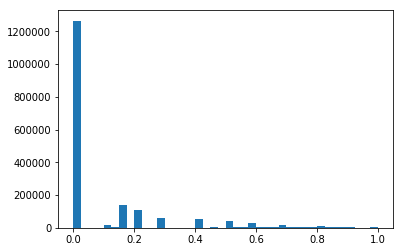

In [29]:
plt.hist(train.target, 40)

In [30]:
train.target.nunique()

2913